# Comparison of zonal statistics with / without grid-cell area weighting

In [1]:
%pip install pystac_client

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import requests
import rasterio
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
from pystac_client import Client
import matplotlib.pyplot as plt

## Load dataset from GHGC STAC catalog

In [3]:
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

COLLECTION_ID = "casagfed-carbonflux-monthgrid-v3"
ASSET_NAME = "npp"

* https://ghg-demo.netlify.app/data-catalog/casagfed-carbonflux-monthgrid-v3/explore?projection=equirectangular%7C%7C&basemapid=light&datetime=2017-12-01T00%3A00%3A00.000Z&position=19.6041%7C-2.2691%7C4.67
* https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/casagfed-carbonflux-monthgrid-v3_User_Notebook.html

In [4]:
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(COLLECTION_ID)

## Inspect the first item

In [5]:
item = next(iter(collection.get_all_items()))
item_uri = item.assets[ASSET_NAME].href

In [6]:
with rasterio.open(item_uri) as ds:
    print(ds.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 720, 'height': 360, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [7]:
with xr.open_dataset(item_uri, engine="rasterio") as xds:
    print(xds)

<xarray.Dataset>
Dimensions:      (band: 1, x: 720, y: 360)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...


## Save a NetCDF copy of the item

In [8]:
with xr.open_dataset(item_uri, engine="rasterio").rename({"x": "lon", "y": "lat"}) as xds:
    xds["lon"].attrs.update({"long_name": "longitude", "units": "degrees_east"})
    xds["lat"].attrs.update({"long_name": "latitude", "units": "degrees_north"})

    if xds["lat"].values[0] > xds["lat"].values[-1]:
        xds = xds.isel(lat=slice(None, None, -1))
        
    xds.to_netcdf("sample.nc")

## Load CDO to compute grid area

```
conda install -n notebook -c conda-forge cdo
cdo gridarea infile outfile
```

https://code.mpimet.mpg.de/boards/1/topics/6998

Btw, the code is here: https://github.com/AZed/cdo/blob/214cb1461beba2dba9848e393427d34f403caec4/src/Gridcell.c#L138

In [9]:
#!conda install -n notebook -c conda-forge cdo

In [10]:
#!cdo gridarea "sample.nc" "area.nc"

In [11]:
with xr.open_dataset("area.nc") as ds:
    area_cdo = ds["cell_area"].values

## Compute area with spherical coordinate formula

In [12]:
def _get_unique_diff(arr):
    assert np.ndim(arr) == 1
    deltas = np.unique(np.diff(arr))
    assert len(deltas) == 1
    return deltas[0]


def spherical_grid_cell_area(lat):
    """
    https://www.mathworks.com/matlabcentral/answers/447847-how-to-calculate-the-area-of-each-grid-cell
    https://gis.stackexchange.com/a/28156
    """
    dlat = _get_unique_diff(lat)
    assert dlat > 0
    
    lat_south = lat - dlat / 2.
    
    R_e = 6371e3 # Radius of Earth in meters
    
    area_lat = R_e ** 2 * (np.sin(np.radians(lat_south + dlat)) - np.sin(np.radians(lat_south))) * np.radians(dlat)
    
    return area_lat

In [13]:
area_lat = spherical_grid_cell_area(xds.lat.values)
area_lat_2d = np.ones((len(xds.lat), len(xds.lon))) * area_lat[:, np.newaxis]

In [14]:
def get_coord_specs(arr):
    assert np.ndim(arr) == 1
    delta = _get_unique_diff(arr)
    return ((arr[0] - delta / 2), (arr[-1] + delta / 2), len(arr))


def surfaceAreaGrid(lat_specs, lon_specs):
    """
    Construct a 2D array (nlat, nlon) where each element is the surface area of the corresponding grid in square meters.
    lat_specs is a tuple, (starting latitude, ending latitude, latitude divisions)
    lon_specs is a tuple, (starting longitude, ending longitude, longitude divisions)

    Example: surfaceAreaGrid((-30,60,45), (20,80,120)) should return a (45,120) array with the surface areas of the
    (2 degree lat x 0.5 degree lon) cells in square meters.
    """
    lat_beg, lat_end, lat_div = lat_specs
    lon_beg, lon_end, lon_div = lon_specs

    R_e = 6371000.0 # Radius of Earth in meters
    dLon = (np.pi / 180.) * (lon_end - lon_beg) / lon_div

    dS = np.zeros((lat_div+1, lon_div), np.float64)

    Lats = (np.pi / 180.) * np.linspace(lat_beg, lat_end, lat_div+1)
    for i, lat in enumerate(Lats):
        dS[i] = R_e * R_e * dLon * np.sin(lat)

    dS = np.diff(dS, axis=0)
    return dS

In [15]:
lat_specs = get_coord_specs(xds.lat.values)
lon_specs = get_coord_specs(xds.lon.values)

In [16]:
lon_beg, lon_end, lon_div = lon_specs
print((lon_end - lon_beg) / lon_div)

0.5


In [17]:
area_sourish = surfaceAreaGrid(lat_specs, lon_specs)

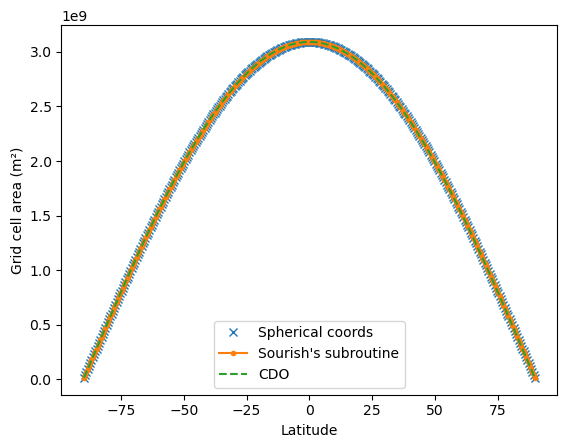

In [18]:
lat = xds.lat.values

plt.plot(lat, area_lat_2d[:, 0], "x", label="Spherical coords")
plt.plot(lat, area_sourish[:, 0], ".-", label="Sourish's subroutine")
plt.plot(lat, area_cdo[:, 0], "--", label="CDO")
plt.ylabel("Grid cell area (m²)")
plt.xlabel("Latitude")
plt.legend() ;

In [19]:
AOI_NAME = "Democratic Republic of Congo (bbox)"

AOI = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              12.2105,
              -13.4584
            ],
            [
              31.2804,
              -13.4584
            ],
            [
              31.2804,
              5.3753
            ],
            [
              12.2105,
              5.3753
            ],
            [
              12.2105,
              -13.4584
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [44]:
AOI_NAME = "the whole globe"

AOI = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -180,
              -89
            ],
            [
              180,
              -89
            ],
            [
              180,
              89
            ],
            [
              -180,
              89
            ],
            [
              -180,
              -89
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [45]:
LIMIT_ITEMS = 15

## Compute averages with Xarray

In [46]:
area_northup = area_cdo[::-1, :]

timeseries = {
    "start_datetime": [],
    "average_weighted": [],
    "average_simple": []
}

for i, item in enumerate(tqdm.tqdm(collection.get_all_items())):
    item_uri = item.assets[ASSET_NAME].href

    with xr.open_dataset(item_uri, engine="rasterio") as xds:
        xds["area"] = xr.DataArray(area_northup, dims=("y", "x"))
        xds_clip = xds.rio.clip([AOI["features"][0]["geometry"]])
        
        data = xds_clip["band_data"].isel(band=0).to_masked_array()
        
        weights = xds_clip["area"].to_masked_array()
        weights.mask = data.mask
        
        timeseries["average_weighted"].append((data * weights).sum() / weights.sum())
        timeseries["average_simple"].append(data.mean())
        timeseries["start_datetime"].append(item.properties["start_datetime"])
    
    if i >= LIMIT_ITEMS:
        break

15it [00:06,  2.47it/s]


In [47]:
df = pd.DataFrame(timeseries).set_index("start_datetime")
df.index = pd.to_datetime(df.index)

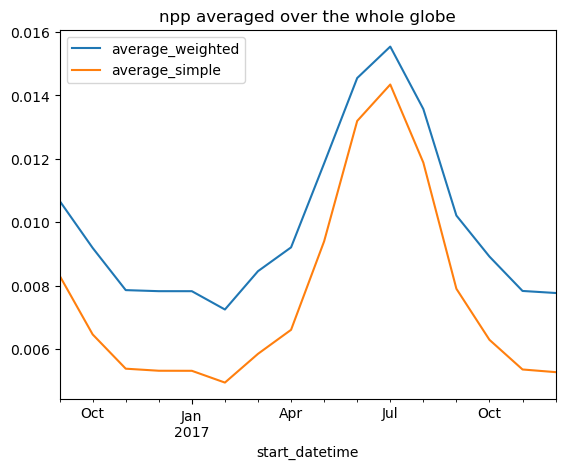

In [48]:
df.plot(title=f"{ASSET_NAME} averaged over {AOI_NAME}") ;

## Compute averages using TiTiler

In [49]:
def generate_stats(item, geojson, asset_name):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item.assets[asset_name].href},
        json=geojson,
    )
    result.raise_for_status()
    result_data = result.json()
    return {
        **result_data["features"][0]["properties"]["statistics"]["b1"],
        "start_datetime": item.properties["start_datetime"],
    }

In [50]:
timeseries_titiler = []

for i, item in enumerate(tqdm.tqdm(collection.get_all_items())):
    timeseries_titiler.append(
        generate_stats(item, AOI, ASSET_NAME)
    )
    
    if i >= LIMIT_ITEMS:
        break

15it [00:03,  3.79it/s]


In [51]:
df_ti = pd.DataFrame(timeseries_titiler)

df_ti = df_ti[["start_datetime", "mean"]]
df_ti = df_ti.set_index("start_datetime")
df_ti.index = pd.to_datetime(df_ti.index)

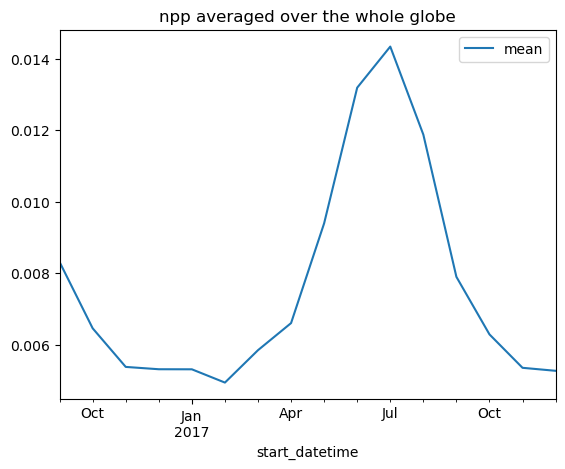

In [52]:
df_ti.plot(title=f"{ASSET_NAME} averaged over {AOI_NAME}") ;

## Rio Tiler with reprojection to equal-area projection

In [53]:
!pip install rio-tiler

In [54]:
from rio_tiler.io import Reader
import rasterio.enums

def generate_stats_rio_titiler(item, geojson, asset_name, dst_crs=None):
    with Reader(item.assets[asset_name].href) as src:
        feature = geojson["features"][0]["geometry"]
        
        if dst_crs is None:
            dst_crs = src.crs
        
        data = src.feature(feature, dst_crs=dst_crs)#, vrt_options={"resampling": rasterio.enums.Resampling.bilinear})

        # Get the coverage % array
        coverage_array = data.get_coverage_array(
            feature,
        )

        stats = data.statistics(
            coverage=coverage_array,
        )       

    return {
        **stats["b1"].model_dump(exclude_none=True),
        "start_datetime": item.properties["start_datetime"],
    }

In [97]:
# https://proj.org/en/9.3/operations/projections/cea.html
WORKING_CRS = rasterio.crs.CRS.from_proj4("+proj=cea")
#WORKING_CRS = rasterio.crs.CRS.from_epsg(9835)
AOI_GEOM = AOI["features"][0]["geometry"]

## Rasterio WarpedVRT and mask.mask

In [98]:
import rasterio.vrt
import rasterio.mask
import rasterio.warp

In [99]:
timeseries_vrt = {
    "start_datetime": [],
    "average_rasterio_warped": [],
    "average_rasterio_original": []
}

for i, item in enumerate(tqdm.tqdm(collection.get_all_items())):

    with rasterio.open(item.assets[ASSET_NAME].href) as ds:

        data_original = ds.read(1, masked=True)

        data_original_masked, _ = rasterio.mask.mask(ds, [AOI_GEOM], crop=True)

        with rasterio.vrt.WarpedVRT(ds, crs=WORKING_CRS) as vrt:
            data_warped = vrt.read(1, masked=True)

            geom_transformed = rasterio.warp.transform_geom(src_crs=rasterio.crs.CRS.from_epsg(4326), dst_crs=WORKING_CRS, geom=AOI_GEOM)

            data_warped_masked, _ = rasterio.mask.mask(vrt, [geom_transformed], crop=True)

            timeseries_vrt["average_rasterio_warped"].append(data_warped_masked.mean())
            timeseries_vrt["average_rasterio_original"].append(data_original_masked.mean())
            timeseries_vrt["start_datetime"].append(item.properties["start_datetime"])

    if i >= LIMIT_ITEMS:
        break

15it [00:05,  2.89it/s]


In [100]:
df_vrt = pd.DataFrame(timeseries_vrt)

df_vrt = df_vrt.set_index("start_datetime")
df_vrt.index = pd.to_datetime(df_ti.index)

In [101]:
timeseries_rio_tiler = []

for i, item in enumerate(tqdm.tqdm(collection.get_all_items())):
    timeseries_rio_tiler.append(
        generate_stats_rio_titiler(item, AOI, ASSET_NAME, dst_crs=WORKING_CRS)
    )
    if i >= LIMIT_ITEMS:
        break

15it [00:06,  2.19it/s]


In [102]:
df_rio = pd.DataFrame(timeseries_rio_tiler)

df_rio = df_rio[["start_datetime", "mean"]]
df_rio = df_rio.set_index("start_datetime")
df_rio.index = pd.to_datetime(df_rio.index)

## Compare all methods together

In [103]:
df_all = df.copy()
df_all["average_titiler"] = df_ti["mean"]
df_all["average_rio_tiler"] = df_rio["mean"]
df_all["average_rasterio_warped"] = df_vrt["average_rasterio_warped"]
df_all["average_rasterio_original"] = df_vrt["average_rasterio_original"]

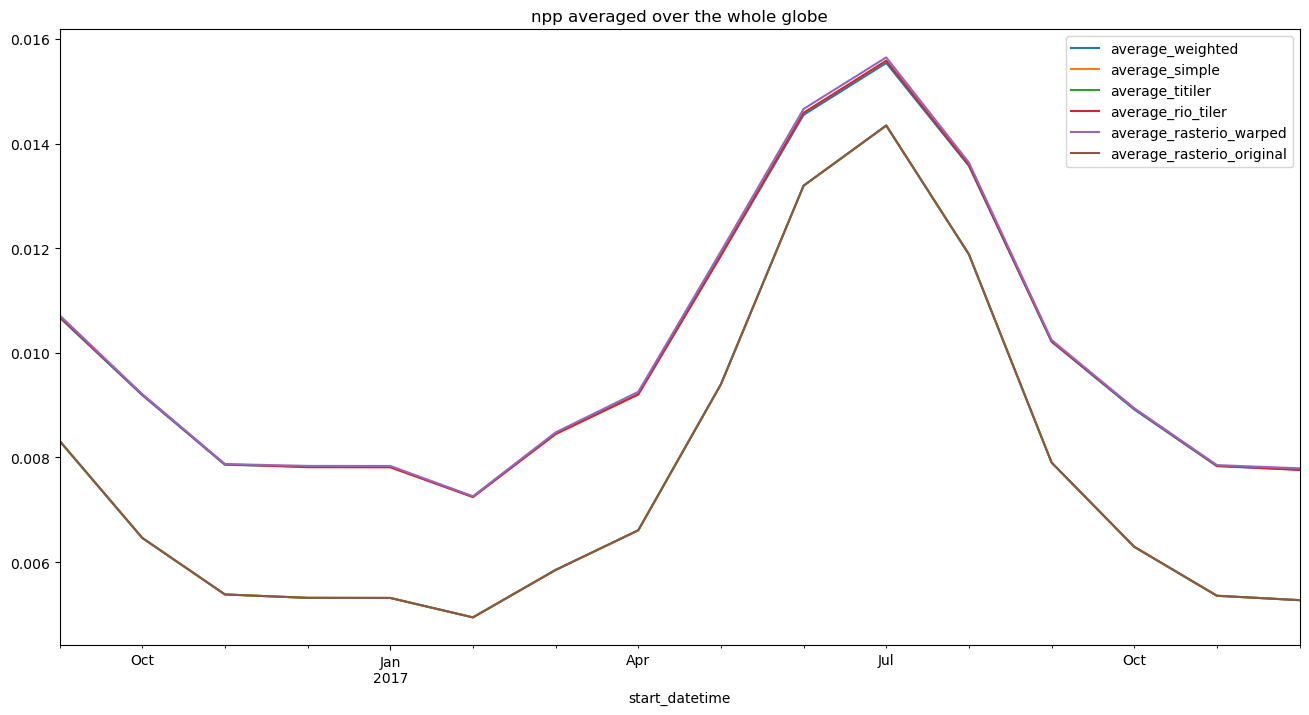

In [104]:
df_all.plot(figsize=(16, 8), title=f"{ASSET_NAME} averaged over {AOI_NAME}") ;

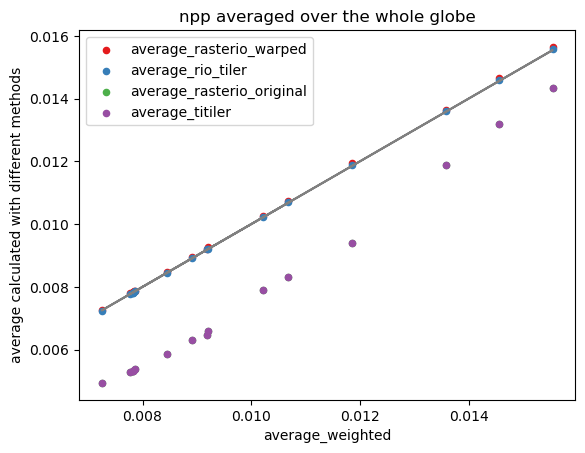

In [105]:
fig = plt.figure()
ax = fig.gca()

import seaborn as sns

for key, style in {
    "average_rasterio_warped": "#e41a1c",
    "average_rio_tiler": "#377eb8",
    "average_rasterio_original": "#4daf4a",
    "average_titiler": "#984ea3"
}.items():
    df_all.plot.scatter("average_weighted", key, ax=ax, c=style, label=key)
    
ax.plot(df_all["average_weighted"], df_all["average_weighted"], color="grey")

ax.set_title(f"{ASSET_NAME} averaged over {AOI_NAME}")
ax.set_ylabel("average calculated with different methods") ;

RMSE of Rasterio WarpedVRT with `cea` intermediate projection

In [106]:
np.sqrt(np.sum((df_all["average_weighted"] - df_all["average_rasterio_warped"])**2))

0.00020784969225849924

RMSE of rio-tiler method with `cea` intermediate projection with manually calculated weighted average

In [107]:
np.sqrt(np.sum((df_all["average_weighted"] - df_all["average_rio_tiler"])**2))

7.405373514196028e-05

RMSE of Rasterio mask.mask with unweighted average on Xarray

In [108]:
np.sqrt(np.sum((df_all["average_simple"] - df_all["average_rasterio_original"])**2))

6.407064432400065e-10

RMSE of TiTiler (no reprojection, API-calculated) with unweighted average on Xarray

In [109]:
np.sqrt(np.sum((df_all["average_simple"] - df_all["average_titiler"])**2))

0.0

In [114]:
crs = rasterio.crs.CRS.from_proj4("+proj=cea")

In [115]:
crs.to_epsg()

In [ ]:
import rio_tiler.io
import rasterio.crs

with rio_tiler.io.Reader(URI) as src:

    data = src.feature(FEATURE, dst_crs=rasterio.crs.CRS.from_proj4("+proj=cea"))

    coverage_array = data.get_coverage_array(
        FEATURE,
    )

    stats = data.statistics(
        coverage=coverage_array,
    )       